In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd

from src.toolkit.config import build_config
from src.data.datazoo import get_dataloaders

# Load example configurations that use the FedMedMNIST LF/LFQ datasets

In [2]:
LF_cfg = build_config('configs/experiments/FedMedMNISTLF_FFP.yaml')
LF_cfg.data_distribution_config.fingerprint = False # turn off so we do not calculate fingerprints here for saving time 
LFQ_cfg = build_config('configs/experiments/FedMedMNISTLFQ_FFP.yaml')
LFQ_cfg.data_distribution_config.fingerprint = False # turn off so we do not calculate fingerprints here for saving time

Loading config from file: configs/experiments/FedMedMNISTLF_FFP.yaml
Loading config from file: configs/bases/paths.yaml
Loading config from file: configs/bases/training/FedMedMNIST_FFP.yaml
Loading config from file: configs/bases/data/FedMedMNISTLF.yaml
Loading config from file: configs/bases/models/CNNPFL.yaml
Loading config from file: configs/bases/fingerprint/FFP.yaml
Loading config from file: configs/experiments/FedMedMNISTLFQ_FFP.yaml
Loading config from file: configs/bases/paths.yaml
Loading config from file: configs/bases/training/FedMedMNIST_FFP.yaml
Loading config from file: configs/bases/data/FedMedMNISTLFQ.yaml
Loading config from file: configs/bases/models/CNNPFL.yaml
Loading config from file: configs/bases/fingerprint/FFP.yaml


# Get both federated dataloaders

In [3]:
LF_dl = get_dataloaders(LF_cfg.data, True, LF_cfg)
LFQ_dl = get_dataloaders(LFQ_cfg.data, True, LFQ_cfg)

Start loading multiple benchmark datasets as federated dataset with 173 clients (['MedMNISTBlood', 'MedMNISTBreast', 'MedMNISTDerma', 'MedMNISTOrganA', 'MedMNISTOrganC', 'MedMNISTOrganS', 'MedMNISTPneumonia', 'MedMNISTRetina']) that are split into ([24, 1, 14, 69, 26, 28, 9, 2]) clients each respectively.
Loading data for 24 clients for MedMNISTBlood
Created central dataloaders for MedMNISTBlood dataset. Transformed them with:
None
Batchsize: 64 | Trainbatches: 186 | Testbatches: 54 | Validationbatches: 27
Splitting central dataset into federated client datasets with a IID partitioning!
Loading distribution from ./data/federated_distributions/NC_24_partition_mode_IID_dataset_MedMNISTBlood_split_TRN_seed_42.tdump
Loading distribution from ./data/federated_distributions/NC_24_partition_mode_IID_dataset_MedMNISTBlood_split_TST_seed_42.tdump
Loading distribution from ./data/federated_distributions/NC_24_partition_mode_IID_dataset_MedMNISTBlood_split_VAL_seed_42.tdump
Federated DataLoaders 

# Prepare dataframes for plotting the training data distributions of both datasets

In [4]:
def target_dists_to_df(fed_data_split, client_order=None):    
    data = []
    for client_id, target_distribution in fed_data_split.items():
        for k, v in target_distribution.items():
            for _ in range(v):
                data.append([client_id, k])
    df = pd.DataFrame(data, columns=['client_id', 'targets'])
    df = df.melt(id_vars=['client_id'], value_name='class')
    df = df.dropna()
    df['class'] = df['class'].astype(int)
    df = df.groupby(['client_id', 'class']).size().reset_index(name='count')

 
    df = df.pivot(index='client_id', columns='class', values='count')
    df = df.fillna(0)

    #reorder clients
    if client_order:
        df = df.reindex(client_order)
    return df

In [5]:
client_to_labelplus = {}
for client, adder in zip(LF_cfg.data.source_client_list, [ 0,  8, 10, 17, 17, 17, 28, 30]):
    client_to_labelplus[client] = adder

adjusted_trn_loader_distributions = {}
for cl, dl in LF_dl.trn_loaders.items():
    cur_adder = client_to_labelplus[cl.split('_')[0]]# add adder to each key in the target distribution dict
    adjusted_trn_loader_distributions[cl] = {int(k)+cur_adder: v for k, v in dl.dataset.target_distribution.items()}

LF_df = target_dists_to_df(adjusted_trn_loader_distributions, client_order=adjusted_trn_loader_distributions.keys())
LF_df

class,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
client_id,,,,,,,,,,,,,,,,,,,,,
MedMNISTBlood_0,32.0,102.0,44.0,72.0,29.0,39.0,99.0,82.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_1,32.0,90.0,46.0,93.0,35.0,39.0,106.0,58.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_2,34.0,98.0,55.0,77.0,41.0,37.0,93.0,64.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_3,37.0,99.0,49.0,73.0,35.0,34.0,94.0,78.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_4,43.0,84.0,41.0,89.0,35.0,40.0,88.0,79.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MedMNISTPneumonia_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,150.0,373.0,0.0,0.0,0.0,0.0,0.0
MedMNISTPneumonia_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,138.0,385.0,0.0,0.0,0.0,0.0,0.0
MedMNISTPneumonia_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,127.0,396.0,0.0,0.0,0.0,0.0,0.0


In [6]:
adjusted_trn_loader_distributions = {}
for cl, dl in LFQ_dl.trn_loaders.items():
    cur_adder = client_to_labelplus[cl.split('_')[0]]# add adder to each key in the target distribution dict
    adjusted_trn_loader_distributions[cl] = {int(k)+cur_adder: v for k, v in dl.dataset.target_distribution.items()}

LFQ_df = target_dists_to_df(adjusted_trn_loader_distributions, client_order=adjusted_trn_loader_distributions.keys())
LFQ_df

class,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
client_id,,,,,,,,,,,,,,,,,,,,,
MedMNISTBlood_0,11.0,392.0,82.0,7.0,32.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_1,1.0,25.0,0.0,89.0,3.0,38.0,5.0,88.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_2,19.0,1.0,10.0,18.0,2.0,108.0,915.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_3,46.0,1.0,319.0,0.0,8.0,8.0,2.0,93.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MedMNISTBlood_4,177.0,80.0,3.0,21.0,8.0,102.0,310.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MedMNISTPneumonia_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,328.0,1.0,0.0,0.0,0.0,0.0,0.0
MedMNISTPneumonia_7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,210.0,13.0,0.0,0.0,0.0,0.0,0.0
MedMNISTPneumonia_8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,45.0,0.0,0.0,0.0,0.0,0.0


# Illustrate the training data distributions of FedMedMNIST LF and LFQ

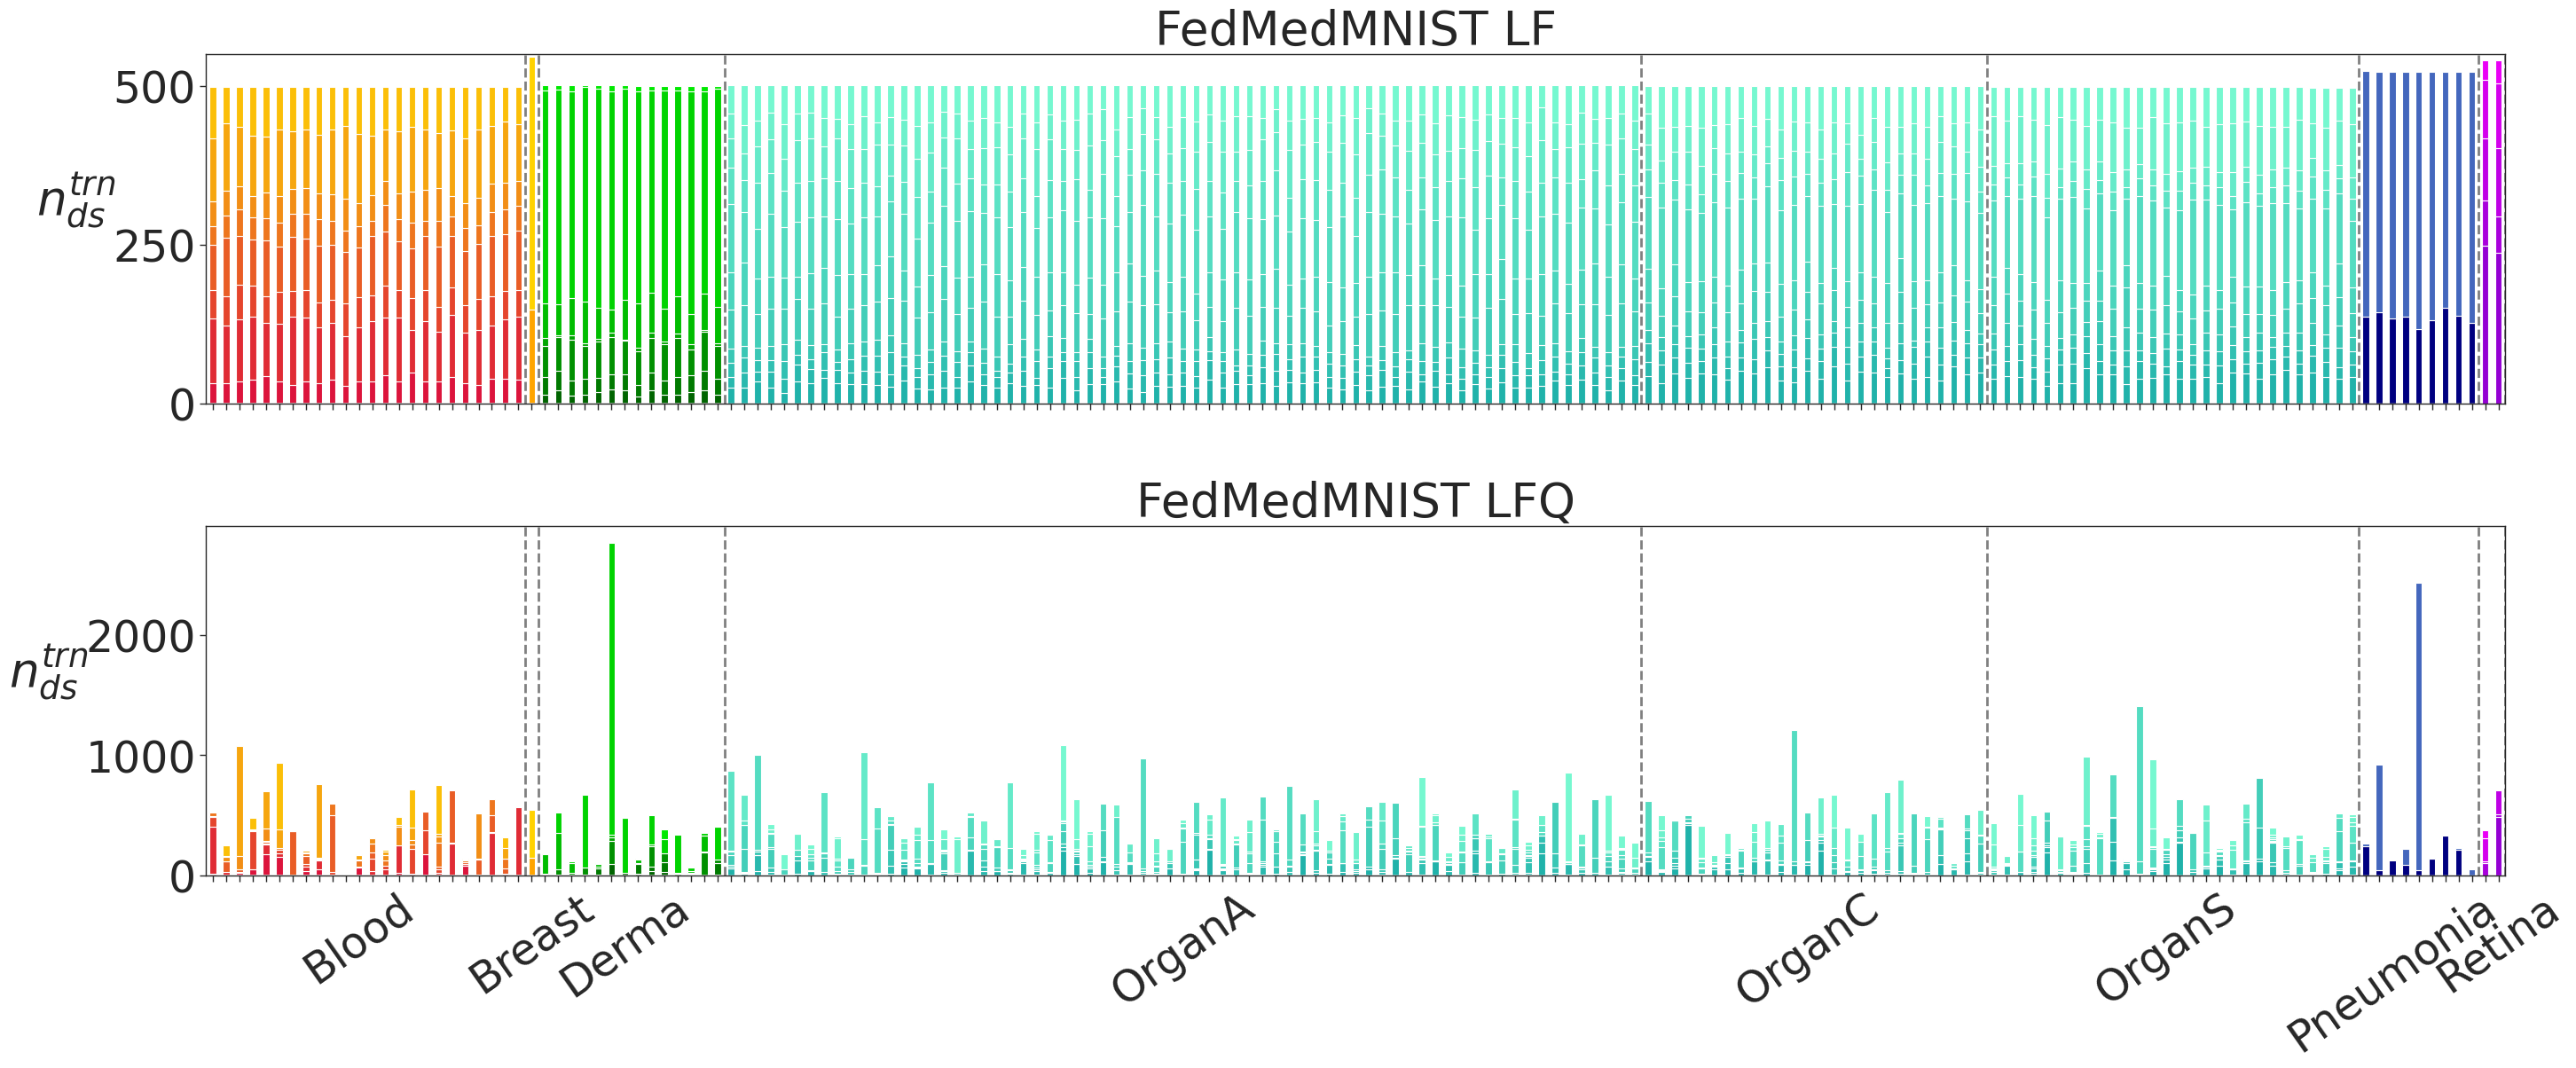

In [7]:
sns.set_style("ticks")
sns.set_context("paper", font_scale=4, rc={"text.usetex": True})

def get_custom_rainbow():
    # Define the base colors and the number of shades for each base color
    base_colors = [('crimson', 'gold'), ('orange', 'yellow'), ('darkgreen', 'lime'), ('lightseagreen', 'aquamarine'), ('navy', 'lightskyblue'), ('darkviolet', 'magenta')]
    shades_count = [8, 2, 7, 11, 2, 5]

    # Initialize an empty list to store colors
    colors = []

    # Generate shades for each base color by interpolating between two colors in base colors
    for base_color, num_shades in zip(base_colors, shades_count):
        # Get the RGB values for the base color
        base_rgb1 = mcolors.to_rgb(base_color[0])
        base_rgb2 = mcolors.to_rgb(base_color[1])

        # Generate shades of the base color from lighter to darker
        for i in range(num_shades):
            # Interpolate RGB vector values for the shade
            shade = [(1 - i / num_shades) * c1 + (i / num_shades) * c2 for (c1, c2) in zip(base_rgb1, base_rgb2)]
            colors.append(shade)

    # Create the color map with the generated shades
    color_map = mcolors.ListedColormap(colors)
    return color_map


color_map = get_custom_rainbow()


#create a bar plot with matplotlib with 2 subplots (below each other)
fig, axs = plt.subplots(2, 1, figsize=(30, 13))

LF_df.plot(kind='bar', stacked=True, ax=axs[0], colormap=color_map)

LFQ_df.plot(kind='bar', stacked=True, ax=axs[1], colormap=color_map)

for i, ax in enumerate(axs):
#remove legend
    ax.get_legend().remove()

    #create vertical grey line between the bars indicated by the list line_after
    line_after = np.cumsum([24, 1, 14, 69, 26, 28, 9, 2])-0.5
    for xc in line_after:
        ax.axvline(x=xc, color='grey', linestyle='--', linewidth=2)

    ax.set_ylabel(r'$n^{trn}_{ds}$', rotation=0, labelpad=30)
    ax.set_xlabel('')
    
    if i == 0:
        ax.set_xticklabels([])
        ax.set_title('FedMedMNIST LF')
        ax.set_ylim(0, 550)
        ax.set_yticks([0, 250, 500])
    
    else:
        x_ticks = ['']*11 + ['Blood'] + ['']*12 + ['Breast'] + ['']*6 + ['Derma']+['']*7 + ['']*34 + ['OrganA']+['']*34 + ['']*12 + ['OrganC']+['']*13 + ['']*13 + ['OrganS']+['']*14 + ['']*2 + ['Pneumonia']+['']*6 +[''] + ['Retina']
        ax.set_xticklabels(x_ticks, rotation=35, ha='center')
        ax.set_title('FedMedMNIST LFQ')

plt.tight_layout()
plt.show()